In [9]:
# 📊 Import required packages
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from einops import rearrange
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../')  # Add the parent directory to the Python path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [10]:
# 📥 Import real models

from models.transformer_model_definitions import InformerForecast, AutoformerForecast, PatchTST

# 📥 Load trained models (optional)
informer_model = InformerForecast().to(device)
informer_model.load_state_dict(torch.load("../models/checkpoints/informer_transformer_model.pth"))
informer_model.eval()

autoformer_model = AutoformerForecast().to(device)
autoformer_model.load_state_dict(torch.load("../models/checkpoints/autoformer_transformer_model.pth"))
autoformer_model.eval()

patchtst_model = PatchTST().to(device)
patchtst_model.load_state_dict(torch.load("../models/checkpoints/patchtst_transformer_model.pth"))
patchtst_model.eval()

PatchTST(
  (patch_embed): Linear(in_features=8, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
# 📂 Load preprocessed dataset
df = pd.read_csv('../data/processed/etth1_processed.csv', parse_dates=["date"], index_col="date")
target = df['OT'].values

In [12]:
# 🧩 TimeSeries Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, window_size):
        self.series = torch.tensor(series, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.series) - self.window_size

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size]
        y = self.series[idx+self.window_size]
        return x.unsqueeze(1), y

# 🔄 DataLoader
window_size = 96
batch_size = 32

dataset = TimeSeriesDataset(target, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print("✅ DataLoader ready!")

✅ DataLoader ready!


In [13]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

In [14]:
# You don’t need to recreate models inside evaluation now.
# Evaluate pre-loaded models
def evaluate_loaded_model(model, model_name):
    preds, trues = [], []
    for x, y in dataloader:
        x, y = x.to(device), y.numpy()
        with torch.no_grad():
            pred = model(x).cpu().numpy()
        preds.append(pred)
        trues.append(y)
    preds = np.concatenate(preds).squeeze()
    trues = np.concatenate(trues)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    s_mape = smape(trues, preds)
    return {'Model': model_name, 'MSE': mse, 'MAE': mae, 'SMAPE': s_mape}

In [17]:
results = []
results.append(evaluate_loaded_model(informer_model, 'Informer'))
results.append(evaluate_loaded_model(autoformer_model, 'Autoformer'))
# Preprocess input for PatchTST model
def evaluate_patchtst_model(model, model_name):
	preds, trues = [], []
	for x, y in dataloader:
		x, y = x.to(device), y.numpy()
		# Reshape input into patches for PatchTST
		x = rearrange(x, 'b (p s) 1 -> b p s', p=x.shape[1] // 8)  # Ensure patch size matches input dimensions
		with torch.no_grad():
			pred = model(x).cpu().numpy()
		preds.append(pred)
		trues.append(y)
	preds = np.concatenate(preds).squeeze()
	trues = np.concatenate(trues)
	mse = mean_squared_error(trues, preds)
	mae = mean_absolute_error(trues, preds)
	s_mape = smape(trues, preds)
	return {'Model': model_name, 'MSE': mse, 'MAE': mae, 'SMAPE': s_mape}

results.append(evaluate_patchtst_model(patchtst_model, 'PatchTST'))

results_df = pd.DataFrame(results)
results_df

,Model,MSE,MAE,SMAPE
0,Informer,0.000367,0.013836,5.015585
1,Autoformer,0.000384,0.014076,5.021801
2,PatchTST,0.002432,0.038487,13.324992


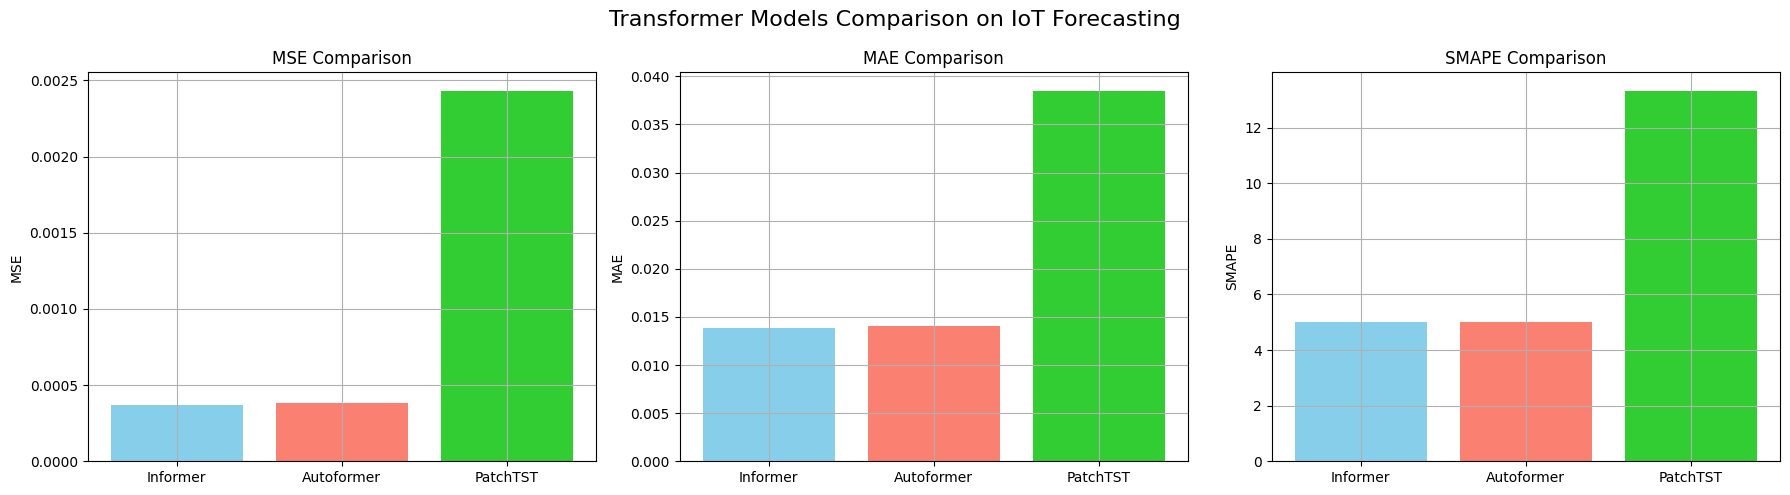

✅ Results saved to comparison_results.csv
✅ Plot saved to comparison_results.png
✅ GPU memory cleared


In [20]:
# 📊 Plot all metrics
metrics = ['MSE', 'MAE', 'SMAPE']
colors = ['skyblue', 'salmon', 'limegreen']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    axs[i].bar(results_df['Model'], results_df[metric], color=colors)
    axs[i].set_title(f'{metric} Comparison')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

plt.suptitle('Transformer Models Comparison on IoT Forecasting', fontsize=16)
plt.tight_layout()
plt.show()

# Save the results to a CSV file
results_df.to_csv('../models/metrics/transformer_comparison_results.csv', index=False)
print("✅ Results saved to comparison_results.csv")
# Save the plot
plt.savefig('../models/metrics/transformer_comparison_results.png')
print("✅ Plot saved to comparison_results.png")
# Close the plot
plt.close()
# Clear GPU memory
torch.cuda.empty_cache()
print("✅ GPU memory cleared")